# OpenPifPaf Image demo

Created from Openpifpaf guide: https://openpifpaf.github.io/intro.html

In [ ]:
# install openpifpaf
!pip install --upgrade openpifpaf==0.10.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 189 kB 27.8 MB/s 
     |████████████████████████████████| 166 kB 64.0 MB/s 
     |████████████████████████████████| 1.4 MB 54.4 MB/s 
  Created wheel for openpifpaf: filename=openpifpaf-0.10.1-cp37-cp37m-linux_x86_64.whl size=411609 sha256=79e56d4d4e03d7a7d432b9066b066b86819c848cdeae43c1290dc3f1c71c0edb
  Stored in directory: /root/.cache/pip/wheels/46/dd/a3/88e2461d388c8f053b3735d67e971a7f885a7bff92b64d1a26
  Created wheel for pysparkling: filename=pysparkling-0.6.1-py3-none-any.whl size=187580 sha256=77c50185ca1887d527c98479a291ab9e33c87f379bc46c81c29935094bd41e9b
  Stored in directory: /root/.cache/pip/wheels/c8/2e/ac/5336e8ec240e9895bf4f142026f16d0d442af578d339c44aa0
Successfully built openpifpaf pysparkling


In [ ]:
import io
import numpy as np
import openpifpaf
import PIL
import requests
import torch

print(openpifpaf.__version__)
print(torch.__version__)

0.10.1
1.12.0+cu113


## Load an Example Image and Display It

In [ ]:
image_response = requests.get('https://images.unsplash.com/photo-1532306486637-1d593e9e0415?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1740&q=80')
pil_im = PIL.Image.open(io.BytesIO(image_response.content)).convert('RGB')
im = np.asarray(pil_im)

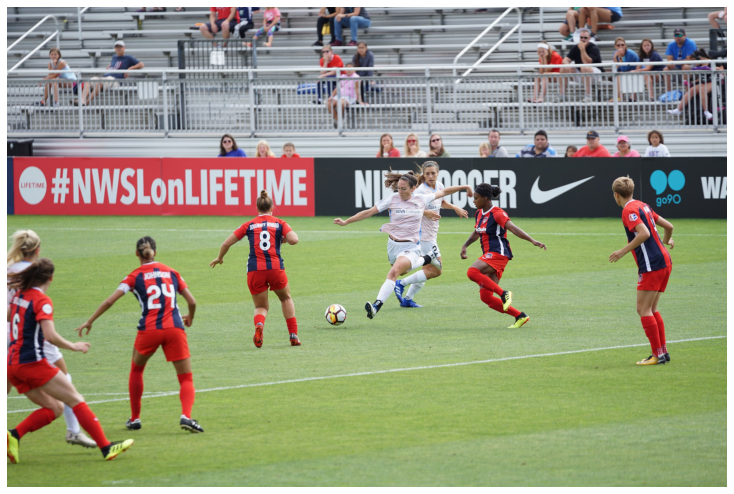

In [ ]:
with openpifpaf.show.image_canvas(im) as ax:
  pass

## Load a Trained Neural Network



In [ ]:
net_cpu, _ = openpifpaf.network.factory(checkpoint='resnet101')

Downloading: "https://github.com/vita-epfl/openpifpaf-torchhub/releases/download/v0.10.0/resnet101block5-pif-paf-paf25-edge401-191012-132602-a2bf7ecd.pkl" to /root/.cache/torch/hub/checkpoints/resnet101block5-pif-paf-paf25-edge401-191012-132602-a2bf7ecd.pkl


  0%|          | 0.00/175M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'openpifpaf.network.nets.Shell' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'openpifpaf.network.basenetworks.BaseNetwork' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attri

In [ ]:
net = net_cpu.cuda()
decode = openpifpaf.decoder.factory_decode(net, 
                                           seed_threshold=0.5)
processor = openpifpaf.decoder.Processor(net, decode, 
                                         instance_threshold=0.2,
                                         keypoint_threshold=0.3)

## Dataset, Dataloader, Visualizer, Prediction

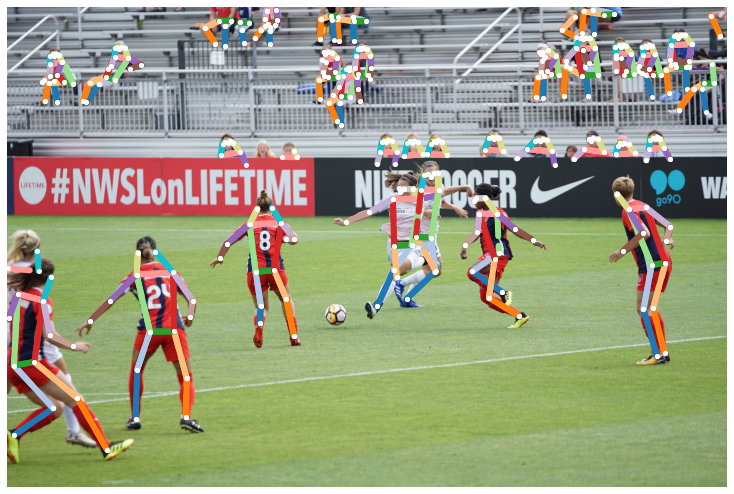

In [ ]:
data = openpifpaf.datasets.PilImageList([pil_im])
loader = torch.utils.data.DataLoader(data, batch_size=1, pin_memory=True)

keypoint_painter = openpifpaf.show.KeypointPainter(color_connections=True, linewidth=6)

for images_batch, _, __ in loader:
  images_batch = images_batch.cuda()
  fields_batch = processor.fields(images_batch)
  predictions = processor.annotations(fields_batch[0])
  
  with openpifpaf.show.image_canvas(im) as ax:
    keypoint_painter.annotations(ax, predictions)